In [1]:
! pip install talib-binary
! pip install colorama

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.4 MB 4.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd


import io
import os
import pathlib

from tqdm.notebook import tqdm
from datetime import datetime, timedelta, time

from matplotlib import pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

from typing import Union, Tuple, List

import time
import json
import random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.io import read_image

from collections import deque
import copy
import talib
import zipfile

import time
import datetime
import math

from colorama import Fore, Back, Style

Mounted at /content/drive


[Котировки цен](https://www.finam.ru/profile/mosbirzha-valyutnyj-rynok/usdrubtod-usd-rub/export/?market=41)

## Обработка цифровых данных

In [3]:
def date_preprocessing(df: pd.DataFrame, secondary_columns: bool = True,
                       labl: str = None) -> pd.DataFrame:
    """
    Начальная предобработка данных, приведение времени к формату datetime
    """
    df_c = df.copy()
    df_c.replace({'<TIME>': {0: '000000'}}, inplace=True)
    df_c['Full_time'] = df_c['<DATE>'].astype('str') + df_c['<TIME>'].astype('str')
    df_c['Full_time'] = pd.to_datetime(df_c['Full_time'], format="%Y%m%d%H%M%S")
    df_c.drop(columns=['<DATE>', '<TIME>'], inplace=True)
    df_c.rename(columns={"<OPEN>": "Open", "<HIGH>": "High", "<LOW>": "Low", 
                    "<CLOSE>": "Close", "<VOL>": "Volume"}, inplace=True)

    if secondary_columns:
        return df_c
    else:
        df_c.rename(columns={"Close": f"Close_{labl}"}, inplace=True)
        return df_c[['Full_time', f"Close_{labl}"]]

In [4]:
def feature_engineering(df: pd.DataFrame) -> pd.DataFrame:
    """
    Добавление новых признаков 
    """
    df_c = df.copy()

    close = df_c['Close']
    high = df_c['High']
    low = df_c['Low']

    macd, _, macdhist = talib.MACD(close)
    df_c['MACD'] = macd
    df_c['MACDh'] = macdhist
    df_c['EMA'] = talib.EMA(close, timeperiod=40)
    slowk, slowd = talib.STOCH(high, low, close)
    df_c['STOCHk'] = slowk
    df_c['STOCHd'] = slowd
    df_c['RSI'] = talib.RSI(close)
    df_c['WILLR'] = talib.WILLR(high, low, close)
    df_c['DIFF'] = df_c['Close'].diff()
    df_c['DEA'] = df_c['EMA'].diff()
    df_c['BOP'] = (df_c['Open'] - df_c['Close']) / (df_c['High'] - df_c['Low'])

    df_c['sin_weekday'] = np.sin(2 * np.pi * df_c['Full_time'].dt.weekday / 6)
    df_c['sin_hour'] = np.sin(2 * np.pi * df_c['Full_time'].dt.hour / 23)
    df_c['sin_minute'] = np.sin(2 * np.pi * df_c['Full_time'].dt.minute / 45)
    df_c['sin_days'] = np.sin(2 * np.pi * df_c['Full_time'].dt.day / 
                                df_c['Full_time'].dt.days_in_month)
    return df_c

In [5]:
# Загрузка данных стоимости акций Сбербанка
df_SBER = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/SBER_200201_220201.csv', sep=';')

# Загрузка данных индекса Московской биржи
df_MOEX = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/IMOEX.csv')

# Загрузка данных индекса D&J
df_DJ = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/D&J-IND.csv')

# Загрузка данных Финансового индекса
df_MOEXFN = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/MOEXFN.csv')

# Загрузка данных курса валюты USD-RUB
df_USD_RUB = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/USD-RUB.csv')


df_SBER = date_preprocessing(df_SBER)
df_MOEX = date_preprocessing(df_MOEX, secondary_columns=False, labl='MOEX')
df_DJ = date_preprocessing(df_DJ, secondary_columns=False, labl='D&J')
df_MOEXFN = date_preprocessing(df_MOEXFN, secondary_columns=False, labl='MOEXFN')
df_USD_RUB = date_preprocessing(df_USD_RUB, secondary_columns=False, labl='USD_RUB')

# Объединяю в единый датафрейм
for ind in [df_MOEX, df_DJ, df_MOEXFN, df_USD_RUB]:
    df_SBER = df_SBER.merge(ind, how='left', on='Full_time')

# Заполняю пропуски предыдущими значениями, так как рынки работают в разное время
df_SBER.fillna(method="bfill", inplace=True)

In [6]:
df_SBER = feature_engineering(df_SBER)

# Удаляю признаки у которых очень высокая корреляция с ценой закрытия Сбера
df_SBER.drop(columns=['High', 'Low', 'Open', 'EMA', 'Close_MOEX'], inplace=True)
df_SBER.dropna(inplace=True)
df_SBER.reset_index(drop=True, inplace=True)

# Направление открытия сделки
df_SBER['Actions'] = 0
# Изменение баланса
df_SBER['Changing balance'] = 0

In [7]:
df_SBER.head()

,Close,Volume,Full_time,Close_D&J,Close_MOEXFN,Close_USD_RUB,MACD,MACDh,STOCHk,STOCHd,...,WILLR,DIFF,DEA,BOP,sin_weekday,sin_hour,sin_minute,sin_days,Actions,Changing balance
0,254.57,2410150,2020-02-04 11:15:00,28400.76892,7418.20,63.3825,0.481716,0.002232,20.780370,27.969071,...,-69.211823,-0.01,0.053524,0.011765,0.866025,0.136167,8.660254e-01,0.762162,0,0
1,253.84,1691650,2020-02-04 11:30:00,28400.76892,7428.46,63.2800,0.393595,-0.068711,11.360628,20.185970,...,-87.192118,-0.73,0.015304,0.678571,0.866025,0.136167,-8.660254e-01,0.762162,0,0
2,253.49,2909530,2020-02-04 11:45:00,28400.76892,7425.79,63.2600,0.292149,-0.136126,13.302033,15.147677,...,-86.830357,-0.35,-0.002516,0.357143,0.866025,0.136167,-2.449294e-16,0.762162,0,0
3,254.06,1839000,2020-02-04 12:00:00,28400.76892,7444.26,63.2400,0.254809,-0.138773,25.164132,16.608931,...,-74.107143,0.57,0.025412,-0.482456,0.866025,-0.136167,0.000000e+00,0.762162,0,0
4,253.83,1191650,2020-02-04 12:15:00,28400.76892,7451.94,63.2225,0.204303,-0.151423,39.825312,26.097159,...,-79.241071,-0.23,0.012953,0.388060,0.866025,-0.136167,8.660254e-01,0.762162,0,0


In [8]:
# Разбиение данных на тестовые и тренировочные

df_SBER_test = df_SBER[(df_SBER['Full_time'] > '2021-10-03')]\
                .reset_index(drop=True)

df_SBER_train = df_SBER[(df_SBER['Full_time'] > '2020-02-06') &
                        (df_SBER['Full_time'] < '2021-08-02')]\
                        .reset_index(drop=True)


print('Размер тренировочной выборки:', df_SBER_train.shape[0])                 
print('Размер тестовой выборки:', df_SBER_test.shape[0])  

Размер тренировочной выборки: 18727
Размер тестовой выборки: 5076


## Визуализация данных

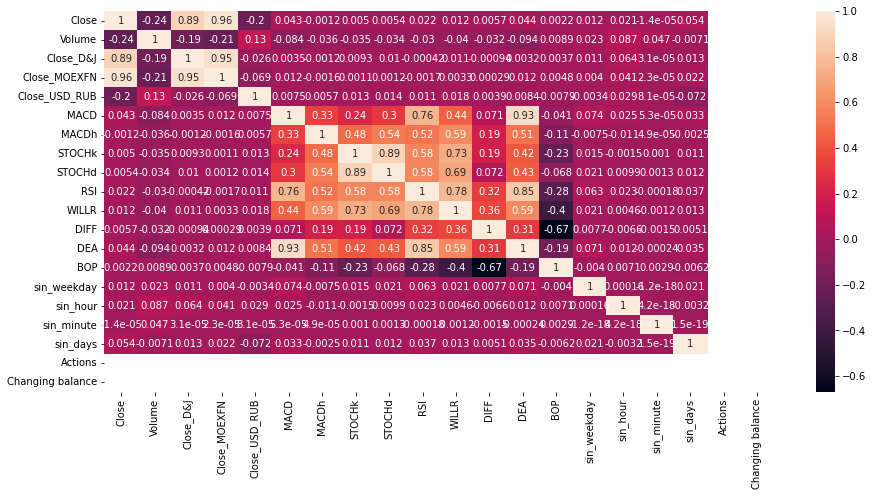

In [9]:
import seaborn as sns

plt.figure(figsize=(15, 7))
sns.heatmap(df_SBER.corr(), annot = True);

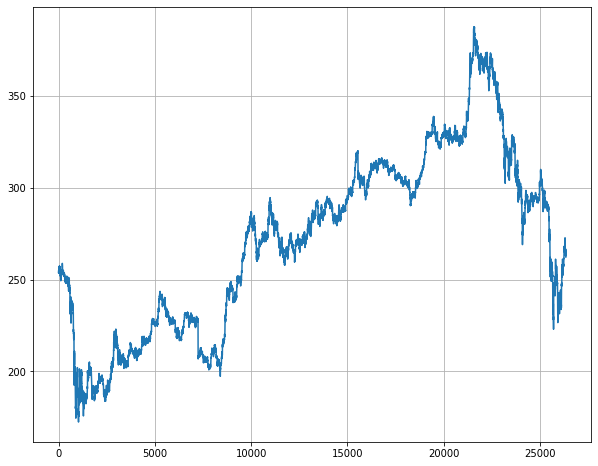

In [10]:
df_SBER['Close'].plot(figsize=(10, 8), grid=True);

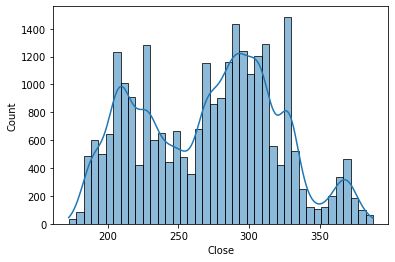

In [11]:
sns.histplot(data=df_SBER, x='Close', kde=True);

## Обработка изображений

In [12]:
# Распаковка файла с фото

fantasy_zip = zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/SBER_image.zip')
fantasy_zip.extractall('/content/')
 
fantasy_zip.close()

In [13]:
def custom_crop_volume(image):
    # Для объема
    return T.functional.crop(image, 357, 140, 120, 580)

def custom_crop_candle(image):
    # Для свечей
    return T.functional.crop(image, 70, 140, 290, 580)  

preprocess_candle = T.Compose([
    T.ToPILImage(),
    T.Grayscale(num_output_channels=1),
    T.ToTensor(),
    T.Lambda(custom_crop_candle),
    T.Resize((290, 390)),
    T.Normalize(
        mean=0.9565,
        std=0.1731
    )
])

preprocess_volume = T.Compose([
    T.ToPILImage(),
    T.Grayscale(num_output_channels=1),
    T.ToTensor(),
    T.Lambda(custom_crop_volume),
    T.Resize((290, 390)),
    T.Normalize(
        mean=0.8322,
        std=0.3393
    )
])

In [14]:
# Преобразование изображения в тензор

path_to_images = '/content/SBER_image'

def image_conversion(df: pd.DataFrame) -> torch.Tensor:
    date_list = df['Full_time'].astype('str').to_list()
    date_list = sorted(list(map(lambda x: x.replace(':', '_') + '.png', date_list)))
    processed_images = []

    for i_name in tqdm(date_list):
        img = read_image(f'{path_to_images}/{i_name}')
        processed_images.append(
            torch.FloatTensor(
                torch.vstack(
                    (preprocess_volume(img), preprocess_candle(img))
                    )
            )
        )
    return processed_images

print('Обработка тестовых изображений.....')
processed_images_test = image_conversion(df_SBER_test)
print('Обработка тренировочных изображений.....')
processed_images_train = image_conversion(df_SBER_train)

Обработка тестовых изображений.....


  0%|          | 0/5076 [00:00<?, ?it/s]

Обработка тренировочных изображений.....


  0%|          | 0/18727 [00:00<?, ?it/s]

Примеры изображения

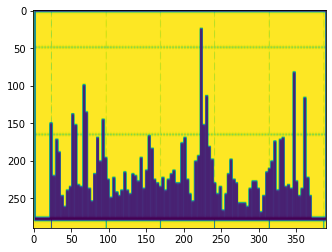

In [15]:
plt.imshow(processed_images_train[10][0].squeeze());

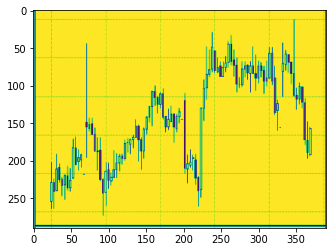

In [16]:
plt.imshow(processed_images_train[10][1].squeeze());

## Торговая среда

In [17]:
class TradingEnv:
    """
   Эмулятор биржи. При каждом шаге выдает новые данные о стоимости и новое изображение.

   Атрибуты:
       data: подготовленные данные со стоимостью акций.
       start_balance: стартовый баланс.
       time_step: размер временного интервала.
       exchange_commission: комиссия биржи, в процентах.
       lot_size: размер лота.
   """

    def __init__(self, data: pd.DataFrame, start_balance: int = 100_000, 
                 time_step: int = 96, exchange_commission: float = 0.1,
                 lot_size: int = 10) -> None:
        self.start_balance = start_balance
        self.time_step = time_step
        self.exchange_commission = exchange_commission
        self.lot_size = lot_size
        self.close_price = data['Close'].to_numpy()
        self.data = data.drop(columns='Full_time').to_numpy()
        self.data_shape = data.shape[0]

    def reset(self) -> Tuple[torch.tensor, int]:
        '''
        Сброс начальных параметров
        '''

        self.number_open_transactions = 0  # Количество открытых сделок
        self.transaction_opening_price = 0  # Цена открытия сделки
        self.action_opening = 0  # Действие на октрытие позиции
        self.balance_history = [self.start_balance]  # История изменения баланса
        self.global_step = 0  # Вычисление номера шага, для вывода следующих данных
        self.balance_at_opening_deal = self.start_balance  # Баланс при открытии сделки
        self.data[:, -2:] = 0  # Обнуление данных о прибыли и открытых сделках
        self.action_history = []  # Список с принятыми действиями
        self.SH_history = []  # Список с изменениями к-нта Шарпа
        self.PR_history = []  # Список с изменениями вознаграждения

        return torch.FloatTensor(
            self.__normalization(self.data[:self.time_step])
            ), self.time_step-1
    

    def __profit_calculation(self, price: float) -> float:
        '''
        Расчет прибыли на каждом шаге
        '''

        commission = self.lot_size * self.exchange_commission *\
                         (price + self.transaction_opening_price) / 100
        profit = self.lot_size * self.action_opening *\
                         (price - self.transaction_opening_price) - commission
        return profit


    def __normalization(self, data: np.ndarray) -> np.ndarray:
        '''
        Нормализация данных перед подачей их в модель
        '''

        norm_data = data[:, :-6].copy()
        not_norm_data = data[:, -6:].copy()
        min_n = norm_data.min(axis=0)
        max_n = norm_data.max(axis=0)
        np.seterr(invalid='ignore')
        norm_data = (norm_data - min_n) / (max_n - min_n)
        norm_data = np.nan_to_num(norm_data, nan=1)
        return np.hstack([norm_data, not_norm_data])


    def __Sharp_ratio(self, risk_free: float = 0.0) -> Tuple[np.ndarray, bool]:
        '''
        Расчет коэффициента Шарпа и значение бездействия за последнии 10 шагов
        '''

        if len(self.balance_history) < self.time_step+1:
            local_start_bln = np.array(self.balance_history[:-1])
            local_bln = np.array(self.balance_history[1:])
        else:
            local_start_bln = np.array(self.balance_history[-self.time_step-1: -1])
            local_bln = np.array(self.balance_history[-self.time_step:])
      
        delta_bln = (local_bln - local_start_bln) / local_start_bln

        # Коэффициент Шарпа
        SR = (np.mean(delta_bln) - risk_free) / (np.std(delta_bln) + 1e-6)
        # Бездействие за 10 шагов
        act_10 = np.array(self.action_history[-10:])
        inaction = np.all(act_10 == act_10[-1])

        if np.isinf(SR) or np.isnan(SR):
            SR = 0.5
        return np.clip(SR, -1, 1), inaction
    

    def step(self, action: int) -> Tuple[Tuple[torch.tensor, int], float, bool, None]:
        '''
        Действия:
        0 - ничего не далать,
        1 - покупка,
        -1 - продажа
        '''

        basic_actions = [-1, 0, 1]
        loc_act = basic_actions[action]
        self.action_history.append(loc_act)

        # Текущая цена закрытия
        current_price = self.close_price[self.global_step + self.time_step - 1]

        # Следующая цена
        next_price = self.close_price[self.global_step + self.time_step]

        # Проверка условия для открытия новой сделки, сделка открывается по
        # current_price цене
        if self.transaction_opening_price == 0 and loc_act != 0:
            self.action_opening = loc_act
            self.transaction_opening_price = current_price
            self.number_open_transactions += 1

        # Проверка условия для закрытия сделки, закрывается по current_price цене
        elif (self.action_opening == 1 and loc_act == -1) or\
        (self.action_opening == -1 and loc_act == 1):
            self.balance_at_opening_deal += self.__profit_calculation(current_price)
            self.action_opening = 0
            self.transaction_opening_price = 0

        # Расчет комиссии и прибыли открытой сделки. Расчет происходит по next_price
        transaction_profit = self.__profit_calculation(next_price)
        self.balance_history.append(
            self.balance_at_opening_deal if self.transaction_opening_price == 0 
            else self.balance_at_opening_deal + transaction_profit
            )
        
        # Вознаграждение(изменение баланса)
        PR = (self.balance_history[-1] - self.balance_history[-2]) /\
                 self.balance_history[-2]

        # Вознаграждение(коэффициент Шарпа)
        SR, inaction = self.__Sharp_ratio()

        # Наказание за бездействие
        punishment_inaction = -0.1 if inaction else 0
        
        self.SH_history.append(SR)
        self.PR_history.append(PR)
        reward = PR * 100 + SR + punishment_inaction

        # В крайнюю колонку добавляя информацию о изменении баланса
        self.data[self.global_step + self.time_step, -1] =\
                (self.balance_history[-1] - self.start_balance) /\
                self.start_balance

        # В предпоседнюю колонку добавляю наличие открытой сделки
        self.data[self.global_step + self.time_step, -2] = self.action_opening

        # Флаг завершения эпизода
        done = True if (self.global_step == self.data.shape[0] - self.time_step - 1
            or self.balance_history[-1] <= 0) else False
        
        self.global_step += 1
        next_state = self.__normalization(
            self.data[self.global_step:self.global_step+self.time_step]
            )
        
        return (torch.FloatTensor(next_state), 
                self.global_step + self.time_step-1), reward, done, None



# DDQN

In [18]:
# Зашумленные слои для нейросети

class NoisyLinear(nn.Linear):
    def __init__(self, in_features, out_features, sigma_init=0.017, bias=True, train=True):
        super(NoisyLinear, self).__init__(in_features, out_features, bias=bias)
        self.train = train
        self.sigma_weight = nn.Parameter(torch.full((out_features, in_features), sigma_init))
        self.register_buffer("epsilon_weight", torch.zeros(out_features, in_features))
        if bias:
            self.sigma_bias = nn.Parameter(torch.full((out_features,), sigma_init))
            self.register_buffer("epsilon_bias", torch.zeros(out_features))
        self.reset_parameters()

    def reset_parameters(self):
        std = math.sqrt(3 / self.in_features)
        self.weight.data.uniform_(-std, std)
        self.bias.data.uniform_(-std, std)

    def forward(self, input):
        self.epsilon_weight.normal_()
        bias = self.bias
        if bias is not None:
            self.epsilon_bias.normal_()
            bias = bias + self.sigma_bias * self.epsilon_bias.data

        if self.train:
            return F.linear(input, self.weight + self.sigma_weight *\
                            self.epsilon_weight.data, bias)
        else:
            return F.linear(input, self.sigma_weight, self.sigma_bias)

In [19]:
class DQN(nn.Module):
    def __init__(self, inp_shape, out_shape, train=True):
        super(DQN, self).__init__()

        self.hidden_layer = 256
        self.num_layers_lstm = 2
        self.lstm_hidden_dig = 256
        self.lstm_hidden_img = 128

        # 1-я часть с цифровыми данными
        self.linear_layer_1 = nn.Sequential(
            nn.Linear(inp_shape, self.hidden_layer),
            nn.ELU(),
            nn.Linear(self.hidden_layer, self.hidden_layer),
            nn.ELU()
        )
        self.lstm = nn.LSTM(self.hidden_layer, self.lstm_hidden_dig, 
                            self.num_layers_lstm, batch_first=True)
        self.linear_dg = nn.Linear(96 * self.lstm_hidden_dig, 1024)
        
        # 2-я часть с изображением
        self.conv_layer = nn.Sequential(
            nn.Conv2d(2, 32, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.bilstm = nn.LSTM(34*47, self.lstm_hidden_img, 1, 
                            batch_first=True, bidirectional=True)
        self.linear_im = nn.Linear(128*128*2, 1024)

        # Создание зашумленных слоев
        self.noisy_layers = [
            NoisyLinear(1536, self.hidden_layer, train=train),
            NoisyLinear(1536, self.hidden_layer, train=train),
            NoisyLinear(self.hidden_layer, out_shape, train=train),
            NoisyLinear(self.hidden_layer, 1, train=train)
        ]
        
        # Объединение двух сетей и переход в DDQN
        self.fc_adv = nn.Sequential(
            self.noisy_layers[0],
            nn.ELU(),
            self.noisy_layers[2]
        )

        self.fc_val = nn.Sequential(
            self.noisy_layers[1],
            nn.ELU(),
            self.noisy_layers[3]
        )

    def forward(self, digital_data, img, h_c):
        batch_size = digital_data.size(0)
        # Присваивание начальго состояния
        h0_d, c0_d, h0_i, c0_i = h_c

        # Цифровые данные
        digital_data = self.linear_layer_1(digital_data)
        _, (hn_d, cn_d) = self.lstm(digital_data, (h0_d, c0_d))
        out_1 = hn_d.reshape(batch_size, -1)

        # Изображение
        img = self.conv_layer(img)
        img = img.reshape(batch_size, 128, -1)
        out_2, (hn_i, cn_i) = self.bilstm(img, (h0_i, c0_i))
        out_2 = out_2.reshape(batch_size, -1)
        out_2 = F.leaky_relu(self.linear_im(out_2))

        # Объединение выходов
        common_out = torch.hstack((out_1, out_2))
        
        val = self.fc_val(common_out)
        adv = self.fc_adv(common_out)
        return val + (adv - adv.mean(dim=1, keepdims=True)),\
                (hn_d, cn_d, hn_i, cn_i)


    def update_hidden_state(self, batch_size: int) -> Tuple[torch.tensor]:
        return (
            torch.zeros([self.num_layers_lstm, batch_size, self.lstm_hidden_dig], device=DEVICE), 
            torch.zeros([self.num_layers_lstm, batch_size, self.lstm_hidden_dig], device=DEVICE),
            torch.zeros([2 * 1, batch_size, self.lstm_hidden_img], device=DEVICE),
            torch.zeros([2 * 1, batch_size, self.lstm_hidden_img], device=DEVICE)
        )

    def noisy_layers_sigma_snr(self) -> List[torch.tensor]:
        return [
            ((layer.weight ** 2).mean().sqrt() / (layer.sigma_weight ** 2).mean().sqrt()).item()
            for layer in self.noisy_layers
        ]

## Сеть с классом

In [20]:
EPISODES = 200
GAMMA = 0.99
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
SYNCHRONZ_MODEL = 1000
SEED = 10
LEARNING_STEP = 2
MIN_BUFFER_SIZE = 200

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Лучшие веса для тестовой модели
PATH_SAVE_MODEL = '/content/drive/MyDrive/Colab Notebooks/model_weight.pth'
# Лучшие веса для тренировочной модели
PATH_SAVE_MODEL_bs = '/content/drive/MyDrive/Colab Notebooks/model_weight_bs.pth'

In [21]:
class ReplayMemory:
    '''
    Буфер памяти

    size: размер буфера.
    images: архив с изображениями.
    '''

    def __init__(self, size: int, images: torch.tensor) -> None:
        self.state = deque(maxlen=size)
        self.action = deque(maxlen=size)
        self.reward = deque(maxlen=size)
        self.next_state = deque(maxlen=size)
        self.done = deque(maxlen=size)
        self.all_mem = [self.state, self.action, self.reward, self.next_state, self.done]
        self.images = images

    def add(self, *args):
        # Добавление новых данных в буфер
        for loc_memory, arg in zip(self.all_mem, args):
            loc_memory.append(arg)
        
    def sample(self, batch_size: int) -> Tuple[torch.tensor]:
        index = np.random.choice(len(self.action), batch_size)

        state_t = torch.cat([self.state[i][0] for i in index]).to(DEVICE)
        action_t = torch.LongTensor([self.action[i] for i in index]).unsqueeze(-1).to(DEVICE)
        reward_t = torch.FloatTensor([self.reward[i] for i in index]).unsqueeze(-1).to(DEVICE)
        next_state_t = torch.cat([self.next_state[i][0] for i in index]).to(DEVICE)
        done_t = torch.FloatTensor([self.done[i] for i in index]).unsqueeze(-1).to(DEVICE)
        num_img_state = [self.state[i][1] for i in index]
        num_img_nstate = [self.next_state[i][1] for i in index]
        image_state = torch.cat([self.images[i].unsqueeze(0) for i in num_img_state]).to(DEVICE)
        image_nstate = torch.cat([self.images[i].unsqueeze(0) for i in num_img_nstate]).to(DEVICE)
        return state_t, action_t, reward_t, next_state_t, done_t, image_state, image_nstate

    def __len__(self):
        return len(self.action)
        

In [22]:
class Agent:
    '''
    Торговый агент

    data: подготовленные данные для обучения
    bufer_size: резмер буфера
    image_archive: преобразованные изображения в тензор pytorch
    test: режим для проверки на тестовых данных
    load_nn_weights: загрузка весов модели из файла
    '''
    def __init__(self, data: pd.DataFrame, bufer_size: int, 
                 image_archive: torch.tensor, test: bool = False, 
                 load_nn_weights: bool = False):

        self.device = DEVICE
        self.image_archive = image_archive
        self.test = test
        self.best_award = -1e10
        self.load_nn_weights = load_nn_weights

        # Создание торговой среды
        self.env = TradingEnv(data, lot_size=80)
        self.action_space = 3
        self.input_data = data.shape[1] - 1
        
        # Создание буфера
        self.buffer = ReplayMemory(bufer_size, image_archive)

        # Создание онлайн и таргет нейросети
        self.net = DQN(self.input_data, self.action_space, train=not(test)).to(DEVICE)

        if self.load_nn_weights:
            self.net.load_state_dict(torch.load(PATH_SAVE_MODEL_bs))
            
        self.target_net = DQN(self.input_data, self.action_space, train=not(test)).to(DEVICE)
        self.target_net.load_state_dict(self.net.state_dict())

        # Функция потерь и оптимизатор
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=LEARNING_RATE)
        self.loss_fn = nn.MSELoss()

        self.mean_reward = deque(maxlen=50)
        self.count_step = 0

    def set_weight(self, W: dict) -> None:
        self.target_net.load_state_dict(W)
        self.net.load_state_dict(W)


    def get_weight(self) -> dict:
        return self.target_net.state_dict()


    def choosing_action(self, state: torch.tensor, 
                        image_number: int, 
                        hc_init: Tuple[torch.tensor]) -> Tuple[int, torch.tensor]:
        image = self.image_archive[image_number].unsqueeze(0).to(DEVICE)
        state = state.to(DEVICE)
        with torch.no_grad():
            Q_val, hc_init = self.net(state, image, hc_init)
        return torch.argmax(Q_val).item(), hc_init


    @torch.no_grad()
    def calculation_target(self, next_state: torch.tensor, 
                           image: torch.tensor, reward: float, done: bool) -> float:
        hc_zero = self.target_net.update_hidden_state(BATCH_SIZE)
        next_step_net_Q = self.net(next_state, image, hc_zero)[0].argmax(1).unsqueeze(-1)
        next_step_target_net_Q = self.target_net(next_state, image, hc_zero)[0].gather(1, next_step_net_Q)
        Q_val = reward + GAMMA * next_step_target_net_Q * (1 - done)
        return Q_val


    def run(self, episode) -> None:
        
        state, num_img_state  = self.env.reset()
        state.unsqueeze_(0)
        episode_reward = 0  # Награда шагов за эпизод
        local_step = 0  # Кол-во шагов за эпизод
        loss_episode = []  # Потери за эпизод
        hc_initial = self.net.update_hidden_state(1)

        while True:
            # Выбор действия
            action, hc_new = self.choosing_action(state, num_img_state, hc_initial)

            # Присваиваю базовым весам новые значения полученные от модели
            hc_initial = hc_new

            (next_state, num_img_nstate), reward, done, _ = self.env.step(action)
            next_state.unsqueeze_(0)
            self.count_step += 1
            local_step += 1
            episode_reward += reward

            # Добавление новых данных в буфер памяти
            self.buffer.add((state, num_img_state), action, reward, 
                            (next_state, num_img_nstate), done)
            
            state = next_state
            num_img_state = num_img_nstate

            if done:
                # Для вычисления среденей награды
                self.mean_reward.append(episode_reward)

                # Получение московского времени
                tz = datetime.timezone(datetime.timedelta(hours=3))
                now = datetime.datetime.now(tz=tz)
                current_time = now.strftime("%H:%M:%S")

                if not self.test:
                    torch.save(self.get_weight(), PATH_SAVE_MODEL_bs)

                # Цвет текста в зависимости обрабатываемых данных
                trade_mode = 'test ' if self.test else 'train'
                color = Fore.GREEN if self.test else Fore.YELLOW

                print(f'{color}{episode+1:03d}_{trade_mode}{Style.RESET_ALL}| Время: {current_time}| '
                    f'Награда: {episode_reward:6.1f}| Шагов: {self.count_step:06d}| Шагов эпз: {local_step:06d}|'
                    f'Баланс: {float(self.env.balance_history[-1]):.1f}| '
                    f'Кол-во сделок: {self.env.number_open_transactions:4d}')
                
                # Вывод соотношения сигнал/шум
                if not self.test:
                    for layer_idx, sigma_l2 in enumerate(self.net.noisy_layers_sigma_snr()):
                        print("sigma_snr_layer_%d" % (layer_idx+1), sigma_l2)
                break
            
            if len(self.buffer) > MIN_BUFFER_SIZE and\
                             self.count_step % LEARNING_STEP == 0:
                self.optimizer.zero_grad()

                # Получение батча примеров из буфера
                state_t, action_t, reward_t, next_state_t, done_t,\
                        image_state, image_nstate = self.buffer.sample(BATCH_SIZE)

                # Вычесление ошибки Q значения
                target_Q = self.calculation_target(next_state_t, image_nstate, reward_t, done_t)
                hc_zero_batch = self.net.update_hidden_state(BATCH_SIZE)
                predict_Q = self.net(state_t, image_state, hc_zero_batch)[0].gather(1, action_t)

                loss = self.loss_fn(predict_Q, target_Q)
                loss_episode.append(loss.item())
                loss.backward()
                self.optimizer.step()

            # Обновление целевой модели
            if self.count_step % SYNCHRONZ_MODEL == 0:
                self.target_net.load_state_dict(self.net.state_dict())


In [ ]:
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

agent_train = Agent(df_SBER_train, 3000, processed_images_train, load_nn_weights=False)
agent_test = Agent(df_SBER_test, 400, processed_images_test, test=True)
start_balanse = 100000

for episode in range(EPISODES):
    agent_train.run(episode)
    weights_train = agent_train.get_weight()
    agent_test.set_weight(weights_train)
    agent_test.run()
    print()
    
    if agent_test.env.balance_history[-1] > start_balanse:
        start_balanse = agent_test.env.balance_history[-1]
        torch.save(weights_train, PATH_SAVE_MODEL)

001_train| Время: 22:15:42| Награда: -2172.3| Шагов: 018631| Шагов эпз: 018631|Баланс: 30369.7| Кол-во сделок: 1590
sigma_snr_layer_1 1.4357755184173584
sigma_snr_layer_2 1.454858660697937
sigma_snr_layer_3 4.26172399520874
sigma_snr_layer_4 10.4815092086792
001_test | Время: 22:22:55| Награда: -488.2| Шагов: 004980| Шагов эпз: 004980|Баланс: 99046.3| Кол-во сделок:   81

002_train| Время: 22:50:45| Награда: -1674.6| Шагов: 037262| Шагов эпз: 018631|Баланс: 51938.9| Кол-во сделок: 1382
sigma_snr_layer_1 1.3336347341537476
sigma_snr_layer_2 1.3500607013702393
sigma_snr_layer_3 4.852748870849609
sigma_snr_layer_4 18.804636001586914
